In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
transform_recipe = transforms.Compose([
    transforms.Resize((128, 128)),  # 모든 사진을 128x128 크기로 변경
    transforms.ToTensor()           # 사진(픽셀)을 파이토치 숫자(Tensor)로 변환
])

In [15]:
train_data = datasets.ImageFolder(root='/content/drive/MyDrive/basketball_data/train', transform=transform_recipe)

In [16]:
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)

In [17]:
print(f"총 이미지 개수: {len(train_data)}장")
print(f"분류할 클래스(정답) 종류: {train_data.classes}")

총 이미지 개수: 90장
분류할 클래스(정답) 종류: ['dunk', 'layup', 'three_point']


In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class ShootClassifier(nn.Module):
    def __init__(self):
        super(ShootClassifier, self).__init__()

        # 1. 특징 추출기 (이미지를 보고 눈코입/공/골대 찾는 부분)
        # Conv2d: 이미지 위를 돋보기로 훑는 필터
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 3채널(컬러) -> 32개 특징
        self.pool = nn.MaxPool2d(2, 2)                          # 사진 크기 반으로 줄이기 (압축)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 특징 32개 -> 64개로 뻥튀기

        # 2. 분류기 (찾은 특징을 보고 "이건 덩크네!" 판단하는 부분)
        # 64개 특징 * 32 * 32 크기 이미지를 한 줄로 쫙 폅니다.
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 3) # 마지막 3은 우리가 분류할 클래스 개수 (dunk, layup, 3point)

    def forward(self, x):
        # 데이터가 통과하는 순서: 입력 -> 필터1 -> 압축 -> 필터2 -> 압축 -> 펴기 -> 판단
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32) # 평평하게 펴기 (Flatten)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ShootClassifier().to(device)

In [21]:
print("모델 제작 완료!")
print(f"현재 사용하는 장치: {device}")

모델 제작 완료!
현재 사용하는 장치: cpu


In [22]:
import torch.optim as optim

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

print("🏀 슛 폼 학습을 시작합니다! (CPU로 진행 중...)")

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # 입력(inputs)과 정답(labels)을 받음
        inputs, labels = data

        # CPU/GPU 장치에 맞게 데이터 이동
        inputs, labels = inputs.to(device), labels.to(device)

        # 변수 초기화 (이전 판의 기록 지우기)
        optimizer.zero_grad()

        # [순전파] 모델에 사진 넣고 예측해보기
        outputs = model(inputs)

        # [손실계산] 정답이랑 얼마나 차이나는지 계산
        loss = criterion(outputs, labels)

        # [역전파] 틀린 만큼 미분해서 오차 찾기
        loss.backward()

        # [최적화] 모델 수정하기
        optimizer.step()

        # 통계 출력용
        running_loss += loss.item()

    # 1번 반복(Epoch) 끝날 때마다 점수 알려주기
    print(f'[{epoch + 1}번째 반복] 오차(Loss): {running_loss / len(train_loader):.4f}')

print('🚀 학습 완료! 모델이 만들어졌습니다.')

🏀 슛 폼 학습을 시작합니다! (CPU로 진행 중...)
[1번째 반복] 오차(Loss): 1.8157
[2번째 반복] 오차(Loss): 1.0834
[3번째 반복] 오차(Loss): 0.9953
[4번째 반복] 오차(Loss): 0.5981
[5번째 반복] 오차(Loss): 0.3727
[6번째 반복] 오차(Loss): 0.2146
[7번째 반복] 오차(Loss): 0.0779
[8번째 반복] 오차(Loss): 0.0802
[9번째 반복] 오차(Loss): 0.0078
[10번째 반복] 오차(Loss): 0.0024
🚀 학습 완료! 모델이 만들어졌습니다.


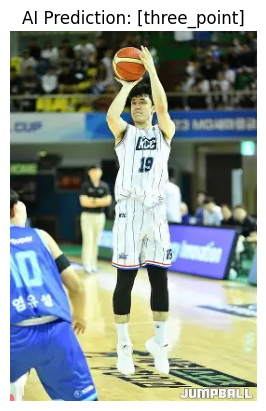

🤖 AI의 분석 결과: 이 사진은 'three_point' 입니다!


In [26]:
import matplotlib.pyplot as plt
from PIL import Image

# 테스트할 이미지 경로 (여기를 수정해서 다양한 사진을 넣어보세요!)
# 예: 왼쪽 파일 목록에 사진을 올리고 경로를 복사해서 붙여넣으세요.
image_path = '/content/drive/MyDrive/basketball_data/test/3점슛.webp'  # <-- 여기에 파일 경로 입력

def predict_shoot(image_path):
    # 1. 이미지 불러오기
    try:
        image = Image.open(image_path)
    except:
        print("❌ 이미지 경로를 확인해주세요! 파일이 없는 것 같아요.")
        return

    # 2. 이미지 변환 (학습할 때랑 똑같이 128x128로 맞추고 텐서로 변환)
    # unsqueeze(0)은 "사진 1장이야"라고 알려주는 차원 추가 (Batch size=1)
    image_tensor = transform_recipe(image).unsqueeze(0).to(device)

    # 3. 모델로 예측하기
    model.eval()  # "지금은 공부 시간이 아니라 시험 시간이야" (평가 모드 설정)
    with torch.no_grad(): # 시험 칠 때는 정답(기울기) 계산 안 함 (메모리 절약)
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1) # 가장 높은 점수를 받은 번호 뽑기

    # 4. 결과 보여주기
    class_names = train_data.classes # ['dunk', 'layup', 'three_point']
    result = class_names[predicted.item()]

    # 사진과 함께 정답 출력
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"AI Prediction: [{result}]") # AI가 예측한 결과
    plt.show()

    print(f"🤖 AI의 분석 결과: 이 사진은 '{result}' 입니다!")

# 함수 실행
predict_shoot(image_path)